In [25]:
import os
import glob
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import pydensecrf.densecrf as dcrf
from tqdm import tqdm
from pydensecrf.utils import unary_from_softmax
import pydicom as dicom

In [26]:
root = "/media/yesindeed/DATADRIVE1/data/NCI-ISBI-2013"

df_images = pd.read_csv(os.path.join(root, "train.txt"),
                        sep=" ", header=None, names=["img_id"])
# df_val = pd.read_csv(os.path.join(root, "val.txt"), sep=" ", header=None, names=["img_id"])
# df_test = pd.read_csv(
#     os.path.join(root, "test.txt"), sep=" ", header=None, names=["img_id"]
# )
# df_images = pd.concat([df_train, df_test], axis=0).reset_index(drop=True)
# df_images

In [27]:
def crf_inference(img, probs, t=10, scale_factor=1, compat=1.5):
    h, w = probs.shape

    probs = probs[None, :, :]
    probs = np.concatenate([1 - probs, probs], axis=0)

    d = dcrf.DenseCRF2D(w, h, 2)
    # unary = fake_prob.reshape((2, -1))
    unary = unary_from_softmax(probs)
    # unary = np.ascontiguousarray(unary)

    d.setUnaryEnergy(unary)
    # d.addPairwiseGaussian(3/scale_factor, compat=10)
    d.addPairwiseBilateral(sxy=80 / scale_factor, srgb=13,
                           rgbim=np.copy(img), compat=compat)

    Q = d.inference(t)
    # crf = np.argmax(Q, axis=0).reshape((h, w))
    crf = np.array(Q)[1].reshape((h, w))

    return crf

In [28]:
def compute_dice(pred, gt):
    inter = np.sum(pred * gt)

    dice = 2 * inter / (np.sum(pred) + np.sum(gt) + 1e-6)

    return dice

In [29]:
scale_factor = 1
t = 10
compat = 1

target = 1

# dice_l = {}

# for i, path in tqdm(enumerate(df_images["img_id"].tolist())):
for i, path in tqdm(enumerate(glob.glob(os.path.join(root, "gaze", "heatmap_50", "*.png")))):
    path = os.path.basename(path).split(".")[0]

    # if path != target_id:
    #     continue
    # if i != target:
    #     continue
    # img = np.array(Image.open(os.path.join(
    #     root, "images", f"{path}.jpg")).convert("RGB"))
    img = dicom.dcmread(os.path.join(
        root, "images", f"{path}.dcm")).pixel_array.astype(np.float32)
    img = (img - img.min()) / (img.max() - img.min()) * 255
    img = Image.fromarray(img.astype(np.uint8)).convert("RGB")
    img = np.array(img)
    gt = np.array(Image.open(os.path.join(
        root, "masks", f"{path}.png")).convert("L"))

    heatmap = Image.open(os.path.join(
        root, "gaze", "heatmap_50", f"{path}.png")).convert("L")
    heatmap = np.array(heatmap).astype(np.float32) / 255

    crf_map = crf_inference(img, heatmap, t=t, scale_factor=1, compat=compat)
    save_folder = os.path.join(root, "gaze", f"crf_compat{compat}")
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    # dice = compute_dice(crf_map > 0.5, gt.astype(np.float32) / 255)
    # dice_l[path] = dice

    crf_map_img = Image.fromarray((crf_map * 255).astype(np.uint8))
    crf_map_img.save(os.path.join(save_folder, f"{path}.png"))

    # np.save(os.path.join(save_folder, f"{path}.npy"), crf_map.astype(np.float16))

0it [00:00, ?it/s]

789it [02:15,  5.83it/s]


In [36]:
dice_crf_l = {}
dice_heatmap_l = {}

thres = 0.2

for i, path in tqdm(enumerate(glob.glob(os.path.join(root, "gaze", "heatmap_50", "*.png")))):
    path = os.path.basename(path).split(".")[0]
    gt = np.array(Image.open(os.path.join(
        root, "masks", f"{path}.png")).convert("L"))
    heatmap = np.array(Image.open(os.path.join(
        root, "gaze", "heatmap_50", f"{path}.png")).convert("L"))
    crf_map = np.array(Image.open(os.path.join(
        root, "gaze", "crf_compat1", f"{path}.png")).convert("L"))

    heatmap = heatmap.astype(np.float32) / 255
    crf_map = crf_map.astype(np.float32) / 255

    dice_heatmap = compute_dice(heatmap > thres, gt.astype(np.float32) / 255)
    dice_crf = compute_dice(crf_map > thres, gt.astype(np.float32) / 255)

    dice_crf_l[path] = dice_crf
    dice_heatmap_l[path] = dice_heatmap

print(np.mean(list(dice_heatmap_l.values())))
print(np.mean(list(dice_crf_l.values())))

0it [00:00, ?it/s]

789it [00:03, 232.51it/s]

0.6085192482447627
0.7760969588288008


Prostate3T-01-0002_6


<Figure size 640x480 with 0 Axes>

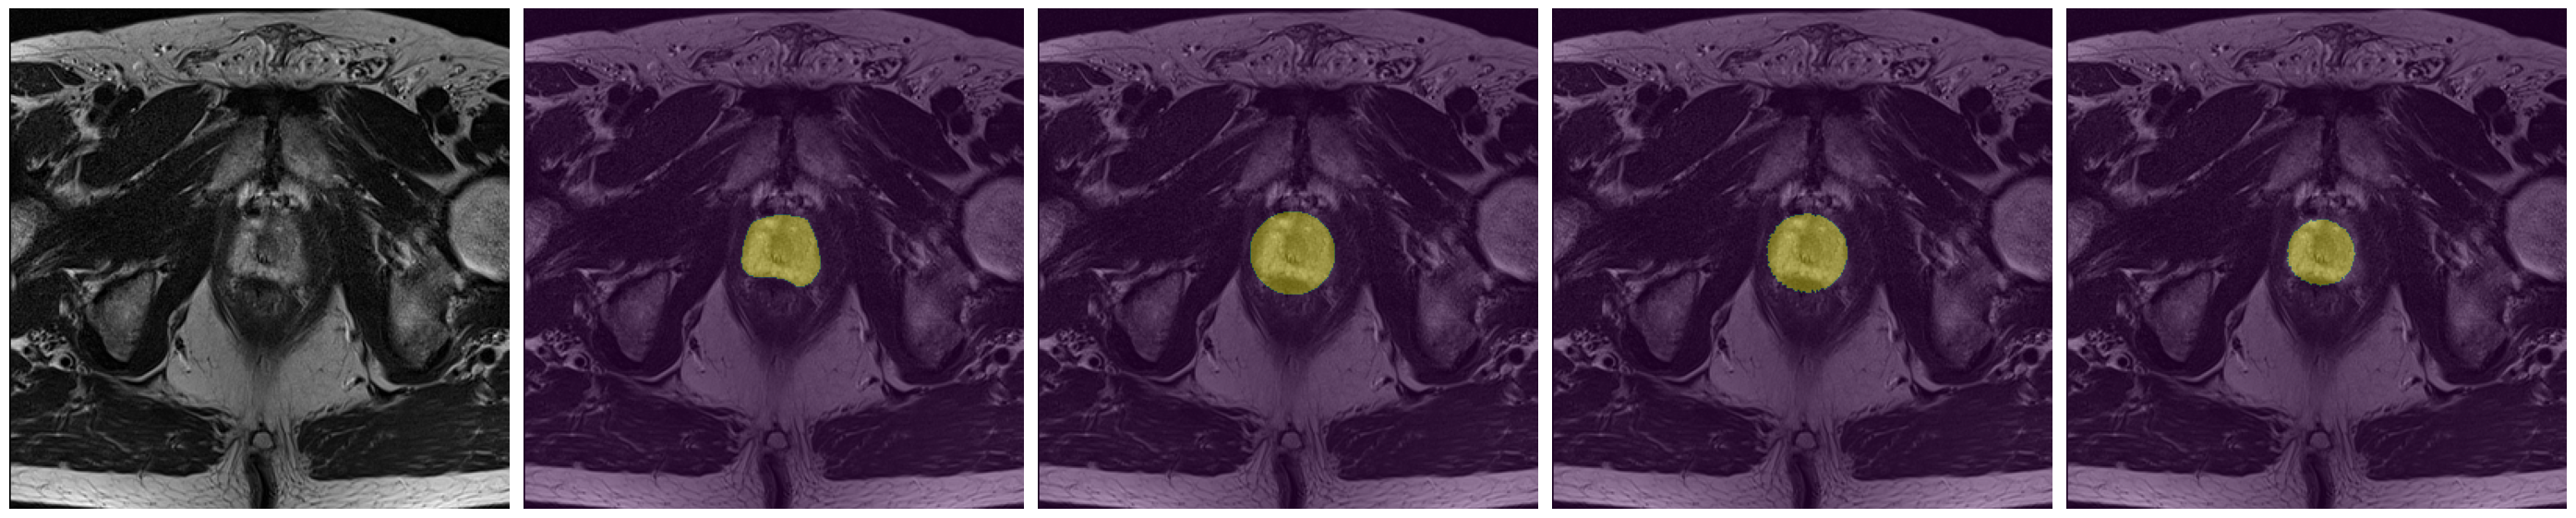

In [40]:
plt.figure()
f, axes = plt.subplots(1, 5, figsize=(28, 6))

path = "Prostate3T-01-0002_6"
# path = "cju30ia8da2bq0799klnehml2"
# path = "cju2iatlki5u309930zmgkv6h"
# path = "cju0qoxqj9q6s0835b43399p4"
# path = "cju0qx73cjw570799j4n5cjze"

# all_paths = glob.glob(
#     "/media/yesindeed/DATADRIVE1/data/Kvasir-SEG/gaze/crf_compat1/*.jpg"
# )
# path = os.path.basename(all_paths[10])[:-4]

img = dicom.dcmread(os.path.join(
    root, "images", f"{path}.dcm")).pixel_array.astype(np.float32)
gt = np.array(Image.open(os.path.join(
    root, "masks", f"{path}.png")).convert("L"))
heatmap = np.array(Image.open(os.path.join(
    root, "gaze", "heatmap", f"{path}.png")).convert("L")) / 255
# heatmap_new = np.array(Image.open(os.path.join(
#     root, "gaze", "heatmap_new", f"{path}.jpg")).convert("L")) / 255
# crf_map_05 = np.array(Image.open(os.path.join(root, "gaze", "crf_compat0.5", f"{path}.jpg")).convert("L")) / 255
crf_map_10 = np.array(Image.open(os.path.join(
    root, "gaze", "crf_compat1", f"{path}.png")).convert("L")) / 255
# crf_map_25 = np.array(Image.open(os.path.join(root, "gaze", "crf_compat2.5", f"{path}.jpg")).convert("L")) / 255

# num 10, ck2da7fwcjfis07218r1rvm95
print(path)

for ax in axes:
    ax.axis("off")

axes[0].imshow(img, cmap="gray")

axes[1].imshow(img, cmap="gray")
axes[1].imshow(gt, alpha=0.4)

# axes[2].imshow(img)
# axes[2].imshow(heatmap, alpha=0.4)

axes[2].imshow(img, cmap="gray")
axes[2].imshow(heatmap > 0.5, alpha=0.4)

axes[3].imshow(img, cmap="gray")
axes[3].imshow(crf_map_10 > 0.3, alpha=0.4)

axes[4].imshow(img, cmap="gray")
axes[4].imshow(crf_map_10 > 0.4, alpha=0.4)

# axes[4].imshow(img)
# axes[4].imshow(crf_map > 0.5, alpha=0.4)

f.tight_layout()